# A Linear Programming Model for Optimal Transport 

<div class="alert alert-block alert-success">
$\newcommand{\R}{\mathbb{R}} \newcommand{\Z}{\mathbb{Z}} \newcommand{\N}{\mathbb{N}} 
\newcommand{\bff}{\mathbf{f}} \newcommand{\bx}{\mathbf{x}} 
\newcommand{\by}{\mathbf{y}} \newcommand{\bo}{\mathbb{1}} \newcommand{\bJ}{\mathbf{J}}$
In this notebook, we will aim to solve the following optimal transport problem in its linear form:
\begin{align}
\min c^\top x,
\end{align}
subject to
\begin{align}
    \begin{pmatrix} \mathbb{1}_N^\top \otimes I_M \\ I_N \otimes \mathbb{1}_M^\top \end{pmatrix} x &= 
    \begin{pmatrix} m \\ n \end{pmatrix},
    \\
    x &\geq 0;
\end{align}
where $x\in \R^{M\times N}$, $m \in \R^M$, $n \in \R^N$, and $c \in \R^{M\times N}$ is a positive cost vector.
</div>

<div class="alert alert-block alert-info">
The following packages are loaded into the environment. 
</div>

In [2]:
from gurobipy import *
import time
import numpy as np
from numpy         import asarray, indices, double, allclose
from pandas        import read_csv
from skimage.io    import imread, imshow
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

<div class="alert alert-block alert-success">
We can actually solve the original problem with an LP solver that allows indexing:
\begin{align}
    \min c : \gamma,
\end{align}
subject to
\begin{align}
    \sum_{j} \gamma_{i,j} &= m_i
    \\
    \sum_{i} \gamma_{i,j} &= n_j
    \\
    \gamma_{i,j} &\geq 0.
\end{align}
</div>

<div class="alert alert-block alert-info">
Here we define the following basic objects:
    
1. `M` and `N` are the number of points where the measures of `μ` and `ν` are concentrated,
2. `c` is the vector of costs.
</div>

In [3]:
# File names
Dir  = '../../DOTmark/Data/MicroscopyImages/'
Main = 'Microscopy_Sized/'
nomᵤ = 'data256_1002.csv'
nomᵥ = 'data256_1010.csv'

In [4]:
μ = read_csv(Dir + nomᵤ).values.astype(double);    μ /= μ.max()
ν = read_csv(Dir + nomᵥ).values.astype(double);    ν /= ν.max()

In [84]:
M = μ.size
N = ν.size

In [85]:
# Coordinates:
Iₘ = (indices(μ.shape)/(asarray(μ.shape)-1)[::,np.newaxis,np.newaxis]).reshape(2,M).T
Iₙ = (indices(ν.shape)/(asarray(ν.shape)-1)[::,np.newaxis,np.newaxis]).reshape(2,N).T
#Sparse alternatives:    indices(μ.shape, sparse=True)      &      indices(ν.shape, sparse=True)

In [86]:
# Cost matrix:
c = cdist(Iₘ, Iₙ, 'sqeuclidean')        # Alternative: distance_matrix(Iₘ, Iₙ) ** 2

In [13]:
P = {'A': (None,'S2'), 'B': (1,'1'), 'C': (1.5,'1.5'), 'D': (2,'2'), 'E': (4,'4'), 'F': (np.inf,'∞')}
test = 'A'

In [14]:
p = '_p=' + P[test][1]

In [9]:
if test != 'A':        c = cdist(Iₘ, Iₙ, 'minkowski', p = P[test][0])

In [9]:
#μ = np.where(μ==0, 1e-4, μ)
#ν = np.where(ν==0, 1e-4, ν)

In [87]:
m = μ.ravel() / μ.sum()
n = ν.ravel() / ν.sum()

<div class="alert alert-block alert-warning">
Optimisation model
</div>

In [88]:
disposeDefaultEnv()

Freeing default Gurobi environment


In [89]:
# Model
start = time.time()
mo = Model()
γ  = {}
γ = mo.addMVar( (M,N), vtype = 'C', name ='g', obj = c, lb = 0.0)

mo.addConstrs( (γ[i,:].sum() == m[i] for i in range(M)), name='m' );
mo.addConstrs( (γ[:,j].sum() == n[j] for j in range(N)), name='n');
end = time.time()
print(end-start)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-10-01
Using license file /Users/andy/gurobi.lic
0.12197589874267578


In [72]:
γ.setAttr('obj', c)

In [90]:
mo.Params.IntFeasTol, mo.Params.FeasibilityTol, mo.Params.OptimalityTol = 1e-9, 1e-9, 1e-9

Changed value of parameter IntFeasTol to 1e-09
   Prev: 1e-05  Min: 1e-09  Max: 0.1  Default: 1e-05
Changed value of parameter FeasibilityTol to 1e-09
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter OptimalityTol to 1e-09
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06


In [91]:
mo.reset();    mo.setParam('Method', 0);    mo.Params.Presolve = 0;    mo.optimize()
#?mo.Params.Method

Discarded solution information
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 128 rows, 4096 columns and 8192 nonzeros
Model fingerprint: 0xea510306
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 5e-02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3555584e+00   9.837282e-01   3.969004e+09      0s
     597    1.6271821e-02   0.000000e+00   0.000000e+00      0s

Solved in 597 iterations and 0.01 seconds
Optimal objective  1.627182145e-02


In [92]:
# Solve with barrier
mo.reset();    mo.setParam('Method', 2);    mo.optimize()

Discarded solution information
Changed value of parameter Method to 2
   Prev: 0  Min: -1  Max: 5  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 128 rows, 4096 columns and 8192 nonzeros
Model fingerprint: 0xea510306
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 5e-02]
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.096e+03
 Factor NZ  : 8.256e+03 (roughly 2 MBytes of memory)
 Factor Ops : 7.073e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.75890378e+02  0.00000000e+00  6.40e+00 0.00e+00  9.22e-02     0s
   1   1.22529475e+01 -5.66548433e-01  4.98e-01 4.44e-16  7.36e-03     0s
   2   3.55930706e-01 -4.75221953e-0

In [93]:
Exact_performance = {
    'Builder': '0.12197589874267578',
    'Simplex': '597 iterations and 0.01 seconds', 
    'Barrier': '104 iterations and 0.05 seconds',
    'Obj': mo.ObjVal
}

<div class="alert alert-block alert-warning">
Output
</div>

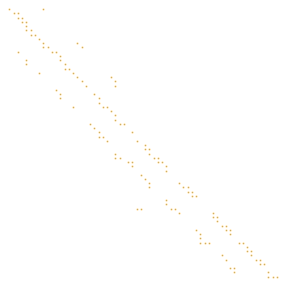

In [95]:
plt.figure(figsize = (5,5))
plt.spy(γ.x, markersize=1, aspect = 1, markeredgecolor = 'orange', alpha=0.5);    plt.axis('off')
plt.savefig(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Plot.pdf', bbox_inches='tight',transparent=True)
plt.show()

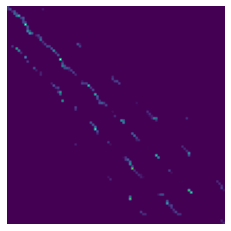

In [78]:
plt.imshow(γ.x[:100,:100]);  plt.axis('off');  
plt.show()

In [14]:
print(γ.x[:13,:3])

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.00064002 0.00030815]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


Now we check that the conditional densities coincide:

In [15]:
allclose(γ.x.sum(0), n), allclose(γ.x.sum(1), m)

(True, True)

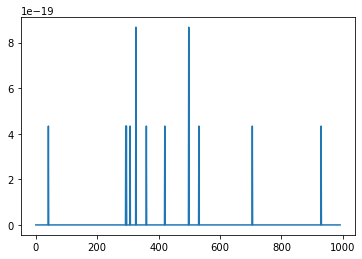

In [16]:
plt.plot( abs(γ.x.sum(0) - n) );    plt.show()

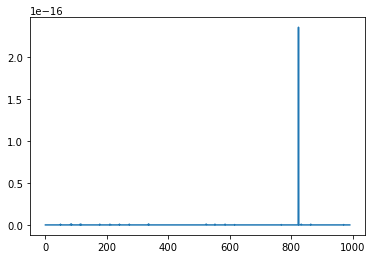

In [17]:
plt.plot( abs(γ.x.sum(1) - m) );    plt.show()

We can then export our inputs and outputs for comparison:

In [96]:
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Cost',   c)    # Cost matrix c
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_m'   ,   m)    # Source measure m
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_n'   ,   n)    # Target measure m
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Sol' , γ.x)    # Source measure m

In [97]:
with open(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Time'+'.txt', 'w') as f:
    print(Exact_performance, file=f)

---

Compress and scale

In [18]:
import os, glob
import h5py            # pip install -U h5py

In [25]:
name = nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Sol'
os.mkdir(Main + name)                                     # Create folder
hf = h5py.File(Main + name + '/' + name + '.h5', 'w')
hf.create_dataset(name, data = γ.x)
hf.close()

In [20]:
name = nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Cost'
os.mkdir(Main + name)                                     # Create folder
hf = h5py.File(Main + name + '/' + name + '.h5', 'w')
hf.create_dataset(name, data = c)
hf.close()

In [21]:
print('./hdf5_manipulator-master/split.py --input ' + name +'/'+name+'.h5 --size 4000')

./hdf5_manipulator-master/split.py --input data128_1002-data128_1010_p=S2_Cost/data128_1002-data128_1010_p=S2_Cost.h5 --size 4000


In [6]:
from skimage.transform import rescale

In [81]:
μ = rescale(μ, 0.5)
ν = rescale(ν, 0.5)

In [82]:
μ.shape, ν.shape

((8, 8), (8, 8))

In [83]:
nomᵤ = 'data8_1002.csv'
nomᵥ = 'data8_1010.csv'

In [29]:
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Cost',   c)    # Cost matrix c
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_m'   ,   m)    # Source measure m
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_n'   ,   n)    # Target measure m

---